# Analysis of BMC solving with Z3

Pandas cheatsheet: https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

There are 4 different encoding parameters:

  - **phi** whether the VC is encoded with phi-assignments. This is traditional encoding for `SeaHorn`
  - **gsa** whether the program is converted to Gated SSA before VCGen. In this case, there are no phi-assignments
  - **ite** whether phi-nodes are encoded with ite-expressions
  - **noite** whether phi-nodes are encoded with disjunction and equalities (traditional for `SeaHorn`)
  
Four combinations are considered: {ite, noite} x {phi, gsa}. 
The combination (ite, phi) is traditional for `SeaHorn`. The combination (ite, gsa) is meaningles since under gsa, there are no phi-nodes, and ite has no effect. Yet, the result show some difference between (ite, gsa) and (noite, gsa). This needs to be investigated further. Possibly the difference is due to usual SAT-solver non-determinism.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [26]:
fname='bmc-z3-sep30.csv'
df = pd.read_csv(fname)
# move timeout and unknown to maximal time
df['time'].fillna(value=900, inplace=True)
# show a snapshot of data for visual validation
df.head()

,index,max_memory,memory,status,time
0,ldv-cat-0000.c.ite.gsa.smt2,0.09,0.09,unknown,900.00
1,ldv-cat-0000.c.ite.phi.smt2,0.09,0.09,unknown,900.00
2,ldv-cat-0000.c.noite.gsa.smt2,0.09,0.09,unknown,900.00
3,ldv-cat-0000.c.noite.phi.smt2,0.09,0.09,unknown,900.00
4,ldv-cat-0001.c.ite.gsa.smt2,3.31,3.01,unsat,0.01


In [27]:
# quick overview of solved/unsolved instances
df[['status','index']].groupby(['status']).count()

,index
status,
memout,2
sat,102
timeout,89
unknown,11
unsat,190


In [28]:
# find all unknown results. Usually means that something went wrong, not just timeout
df.query('status == "unknown"')

,index,max_memory,memory,status,time
0,ldv-cat-0000.c.ite.gsa.smt2,0.09,0.09,unknown,900.0
1,ldv-cat-0000.c.ite.phi.smt2,0.09,0.09,unknown,900.0
2,ldv-cat-0000.c.noite.gsa.smt2,0.09,0.09,unknown,900.0
3,ldv-cat-0000.c.noite.phi.smt2,0.09,0.09,unknown,900.0
332,ldv-cat-0083.c.ite.phi.smt2,0.09,0.09,unknown,900.0
334,ldv-cat-0083.c.noite.phi.smt2,0.09,0.09,unknown,900.0
335,ldv-cat-0084.c.ite.gsa.smt2,0.09,0.09,unknown,900.0
336,ldv-cat-0084.c.ite.phi.smt2,0.09,0.09,unknown,900.0
337,ldv-cat-0084.c.noite.gsa.smt2,0.09,0.09,unknown,900.0
338,ldv-cat-0084.c.noite.phi.smt2,0.09,0.09,unknown,900.0


In [29]:
# split results into 4 groups
def flt_index(df, s):
    return df[df['index'].str.contains(s)]

noite_gsa = flt_index(df, r'\.noite.gsa')
ite_gsa = flt_index(df, r'\.ite.gsa')
ite_phi = flt_index(df, r'\.ite.phi')
noite_phi = flt_index(df, r'\.noite.phi')

## Solved / Unsolved for each group

In [30]:
noite_gsa.groupby('status').count()

,index,max_memory,memory,time
status,,,,
memout,1,0,0,1
sat,21,21,21,21
timeout,26,26,26,26
unknown,3,3,3,3
unsat,48,48,48,48


In [31]:
ite_gsa.groupby('status').count()

,index,max_memory,memory,time
status,,,,
memout,1,0,0,1
sat,21,21,21,21
timeout,25,25,25,25
unknown,2,2,2,2
unsat,48,48,48,48


In [32]:
ite_phi.groupby('status').count()

,index,max_memory,memory,time
status,,,,
sat,26,26,26,26
timeout,23,23,23,23
unknown,3,3,3,3
unsat,47,47,47,47


In [33]:
noite_phi.groupby('status').count()

,index,max_memory,memory,time
status,,,,
sat,34,34,34,34
timeout,15,15,15,15
unknown,3,3,3,3
unsat,47,47,47,47


In [34]:
# create a file column to join different result sets
def index_to_file(df):
    return df.assign(file=df['index'].str.extract(r'([^.]+)'))
noite_phi = index_to_file(noite_phi)
ite_phi = index_to_file(ite_phi)
noite_gsa = index_to_file(noite_gsa)
ite_gsa = index_to_file(ite_gsa)

In [35]:
# join on file
phi = ite_phi.merge(noite_phi, on='file', suffixes=('_ite', '_noite'))

In [36]:
# solved / unsolved based on ite parameter
phi.groupby(['status_ite', 'status_noite']).count()[['file']]

file
status_ite status_noite      
sat        sat             25
           timeout          1
timeout    sat              9
           timeout         14
unknown    unknown          3
unsat      unsat           47

In [37]:
# merge gsa sets and show solved / unsolved
gsa = ite_gsa.merge(noite_gsa, on='file', suffixes=('_ite', '_noite'))
gsa.groupby(['status_ite', 'status_noite']).count()[['file']]

,,file
status_ite,status_noite,
memout,memout,1
sat,sat,21
timeout,timeout,25
unknown,unknown,2
unsat,unsat,48


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


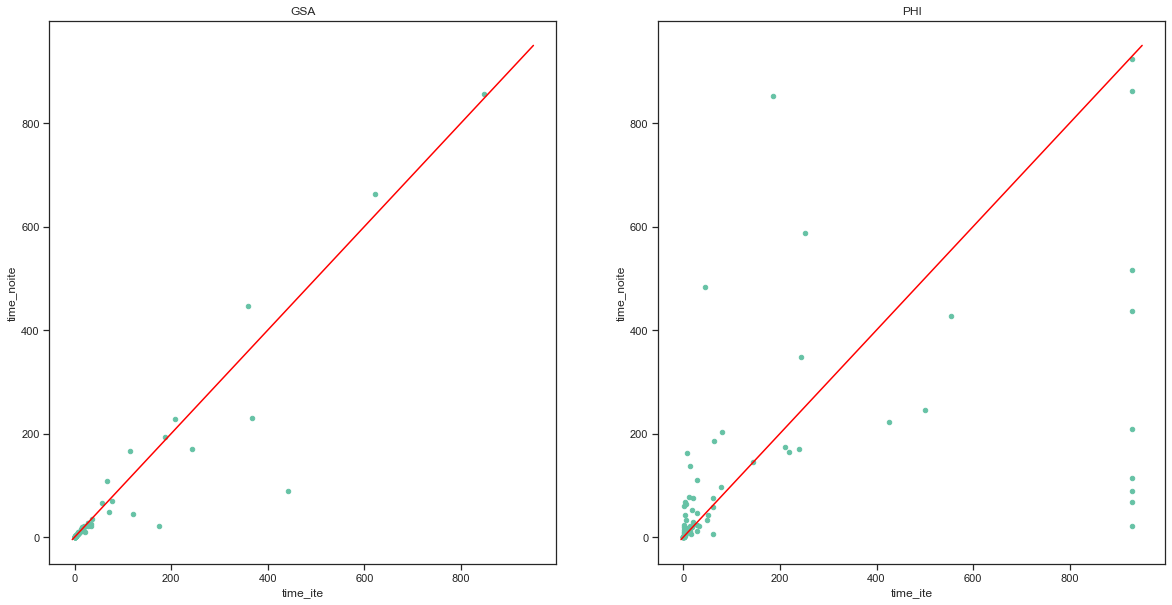

In [38]:
# set default figure size for plots to be 7 by 7 inches
plt.rcParams["figure.figsize"] = (7, 7)
# create a new figure 20 by 10 inches wide
fig = plt.figure(figsize=(20,10))
# break figure into two sub-plots
# ax1: the number '121' is parsed as plot 1 of 1x2 grid
ax1 = plt.subplot(121)
# ax2: the number '122' is parsed as plot 2 of 1x2 grid
ax2 = plt.subplot(122)
# plot a diagonal line to make scatter plots easier to read
x = np.linspace(-5, 950, 2)
ax1.plot(x, x, color='red')
ax2.plot(x, x, color='red')
# plot succeeded instances
gsa.query('status_ite=="sat" or status_ite=="unsat"').plot.scatter(x='time_ite', y='time_noite', ax=ax1, title='GSA')
phi.query('status_noite=="sat" or status_ite=="unsat"').plot.scatter(x='time_ite', y='time_noite', ax=ax2, title='PHI')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


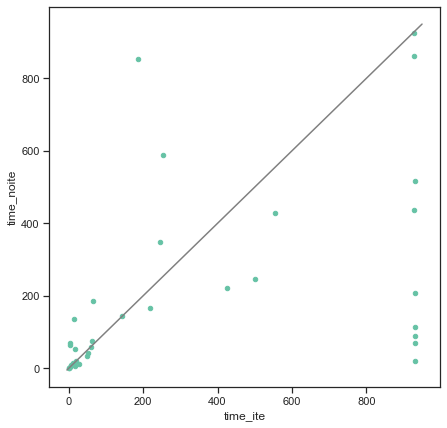

In [39]:
# a single plot is easier to create
ax = phi.query('status_noite=="sat"').plot.scatter(x='time_ite', y='time_noite')
ax.plot(x, x, color='grey')

In [40]:
# summary of the plot. Useful to validate what is visible from the picture
phi.groupby(['status_ite', 'status_noite'])[['time_ite', 'time_noite']].describe()

time_ite                                           \
                           count        mean         std     min      25%   
status_ite status_noite                                                     
sat        sat              25.0  117.251200  163.308958    0.28   10.180   
           timeout           1.0  716.620000         NaN  716.62  716.620   
timeout    sat               9.0  929.705556    0.320043  928.92  929.610   
           timeout          14.0  929.291429    0.384405  928.69  928.995   
unknown    unknown           3.0  900.000000    0.000000  900.00  900.000   
unsat      unsat            47.0   20.701489   47.878819    0.01    0.285   

                                                  time_noite              \
                             50%      75%     max      count        mean   
status_ite status_noite                                                    
sat        sat            47.930  186.340  554.74       25.0  150.931600   
           timeout       716.620  716.620  716.62        1.0  929.510000   
timeout    sat           929.830  929.880  929.93        9.0  360.122222   
           timeout       929.335  929.500  929.86       14.0  929.122857   
unknown    unknown       900.000  900.000  900.00        3.0  900.000000   
unsat      unsat           2.640   17.015  240.42       47.0   42.272128   

                                                                               
                                std     min      25%     50%      75%     max  
status_ite status_noite                                                        
sat        sat           208.426704    0.92   14.140   63.49  185.880  852.80  
           timeout              NaN  929.51  929.510  929.51  929.510  929.51  
timeout    sat           345.973244   21.06   88.800  208.75  515.820  924.63  
           timeout         0.542890  928.07  928.805  929.17  929.475  929.84  
unknown    unknown         0.000000  900.00  900.000  900.00  900.000  900.00  
unsat      unsat          83.658887    0.01    1.065    9.30   37.820  482.72

In [41]:
# seaborn provides useful fancy plots
import seaborn as sns
sns.set(style='ticks', palette='Set2')

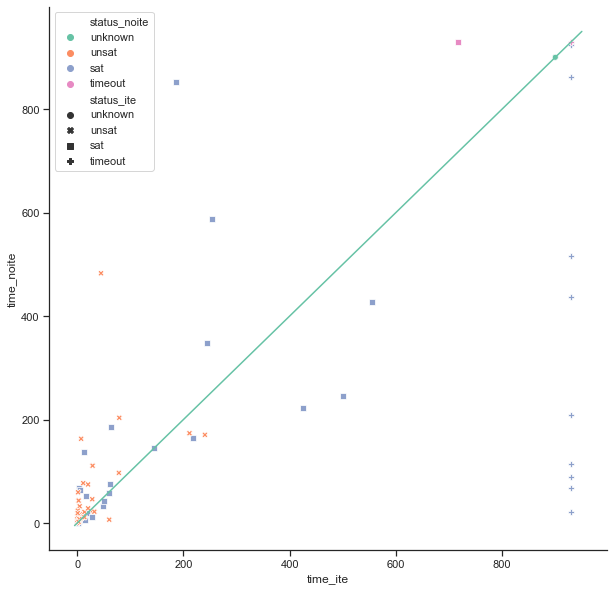

In [42]:
# use additional semantic features to separate sat/unsat instances
# there is a bug in display of the legend that only shows shapes but not colors
fig = plt.figure(figsize=(10,10))
g = sns.scatterplot(x="time_ite", y="time_noite", hue="status_noite", style='status_ite', data=phi);
sns.despine()
g.plot(x, x)


In [43]:
import plotly.express as px
fig = px.scatter(phi, x="time_ite", y="time_noite", color="status_noite", symbol="status_ite")
fig.show()

In [44]:
phi.query('time_noite < 50').sort_values('time_noite')

,index_ite,max_memory_ite,memory_ite,status_ite,time_ite,file,index_noite,max_memory_noite,memory_noite,status_noite,time_noite
1,ldv-cat-0001.c.ite.phi.smt2,3.31,3.01,unsat,0.01,ldv-cat-0001,ldv-cat-0001.c.noite.phi.smt2,3.32,3.01,unsat,0.01
2,ldv-cat-0002.c.ite.phi.smt2,3.37,3.13,unsat,0.01,ldv-cat-0002,ldv-cat-0002.c.noite.phi.smt2,3.37,3.13,unsat,0.01
3,ldv-cat-0003.c.ite.phi.smt2,3.31,3.01,unsat,0.01,ldv-cat-0003,ldv-cat-0003.c.noite.phi.smt2,3.31,3.01,unsat,0.01
4,ldv-cat-0004.c.ite.phi.smt2,3.45,3.14,unsat,0.01,ldv-cat-0004,ldv-cat-0004.c.noite.phi.smt2,3.45,3.14,unsat,0.01
5,ldv-cat-0005.c.ite.phi.smt2,3.74,3.43,unsat,0.01,ldv-cat-0005,ldv-cat-0005.c.noite.phi.smt2,3.74,3.43,unsat,0.01
6,ldv-cat-0006.c.ite.phi.smt2,3.74,3.46,unsat,0.01,ldv-cat-0006,ldv-cat-0006.c.noite.phi.smt2,3.75,3.45,unsat,0.01
7,ldv-cat-0007.c.ite.phi.smt2,4.13,3.87,unsat,0.02,ldv-cat-0007,ldv-cat-0007.c.noite.phi.smt2,4.22,3.97,unsat,0.01
8,ldv-cat-0008.c.ite.phi.smt2,6.36,5.40,unsat,0.03,ldv-cat-0008,ldv-cat-0008.c.noite.phi.smt2,6.23,5.34,unsat,0.03
25,ldv-cat-0025.c.ite.phi.smt2,20.35,16.28,unsat,0.10,ldv-cat-0025,ldv-cat-0025.c.noite.phi.smt2,20.21,16.77,unsat,0.11
11,ldv-cat-0011.c.ite.phi.smt2,38.06,12.29,unsat,0.26,ldv-cat-0011,ldv-cat-0011.c.noite.phi.smt2,49.03,16.74,unsat,0.57
